In [168]:
pip install matplotlib

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [169]:
pip install statsmodels

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [170]:
pip install tqdm

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
from tqdm import tqdm
from multiprocessing.dummy import Pool
import statsmodels.formula.api as smf
pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [80]:
crsp_df = pd.read_csv("crsp.zip", compression='zip',header=0,
             parse_dates = ['date','DCLRDT','RCRDDT'],
             dtype={"PRC": np.float64,
                  "VOL": np.float64,
                  "SHROUT": np.float64,
                  "DIVAMT": np.float64,
                  "SPREAD": np.float64,
                  "SHRCD":str,
                  "DISTCD":str,
                  "COMNAM": str,
                  "TICKER": str,
                   'CUSIP': str})
#Data Preprocessing
crsp_df = crsp_df[(crsp_df.SHRCD.isin(('10','11')))]
crsp_df = crsp_df[(crsp_df.date >= '1927-01-01')]
crsp_df = crsp_df[(crsp_df.date <= '2011-12-31')]
cusips_DISTCD_12 = crsp_df[crsp_df.DISTCD.apply(lambda x: x[:2]=='12' if isinstance(x, str) else False)].CUSIP.unique()
crsp_df = crsp_df[crsp_df.CUSIP.isin(cusips_DISTCD_12)]

crsp_df.PRC = crsp_df.PRC.abs()


crsp_df['year'] = crsp_df['date'].dt.year
crsp_df['month'] = crsp_df['date'].dt.month
crsp_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_df['PRC_t-1'] = crsp_df.groupby('CUSIP')['PRC'].shift(1)
crsp_df.head()


,PERMNO,date,SHRCD,TICKER,COMNAM,CUSIP,DCLRDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,RET,SHROUT,SPREAD,RETX,year,month,PRC_t-1
1359100,25881,1970-11-30,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,318.0,C,2655.0,NaN,C,1970,11,NaN
1359101,25881,1970-12-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,10.000,646.0,0.111111,2655.0,NaN,0.111111,1970,12,9.000
1359102,25881,1971-01-29,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,636.0,-0.100000,2655.0,NaN,-0.100000,1971,1,10.000
1359103,25881,1971-02-26,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,11.125,2155.0,0.236111,2655.0,NaN,0.236111,1971,2,9.000
1359104,25881,1971-03-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.750,2062.0,-0.123596,2655.0,NaN,-0.123596,1971,3,11.125


In [81]:
crsp_div_df = crsp_df[['date','CUSIP','DCLRDT','RCRDDT','DISTCD','DIVAMT','PRC','PRC_t-1','RET','SHROUT','month']].copy()
crsp_div_df 
# crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df = crsp_div_df.groupby(by=['CUSIP','date']).agg({
     'DCLRDT': 'last',
     'RCRDDT': 'last',
     'DISTCD': 'last',
     'DIVAMT': 'last',
     'RET':'last',
     'PRC': 'last',
     'PRC_t-1': 'last',
     'SHROUT': 'last'})
# crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df['freq'] = None
crsp_div_df['freq'] = crsp_div_df[crsp_div_df.RCRDDT.isna()==False]['DISTCD'].apply(lambda x: x[2:3] if x is not None else None)

# fil_C = (crsp_div_df["PRC_t-1"] >= 5) & (crsp_div_df.freq < '6')
# crsp_div_df = crsp_div_df[fil_C]

crsp_div_df['MCAP'] = crsp_div_df['PRC'] * crsp_div_df['SHROUT']
crsp_div_df

DCLRDT RCRDDT DISTCD  DIVAMT        RET     PRC  PRC_t-1  \
CUSIP    date                                                                  
00003210 1970-11-30    NaT    NaT   None     NaN          C   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN   0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN  -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN   0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN  -0.123596   9.750   11.125   
...                    ...    ...    ...     ...        ...     ...      ...   
N5946510 2011-08-31    NaT    NaT   None     NaN  -0.089113  20.750   22.780   
         2011-09-30    NaT    NaT   None     NaN  -0.181205  16.990   20.750   
         2011-10-31    NaT    NaT   None     NaN   0.151854  19.570   16.990   
         2011-11-30    NaT    NaT   None     NaN  -0.002044  19.530   19.570   
         2011-12-30    NaT    NaT   None     NaN   0.098822  21.460   19.530   

                       SHROUT freq         MCAP  
CUSIP    date                                    
00003210 1970-11-30    2655.0  NaN    23895.000  
         1970-12-31    2655.0  NaN    26550.000  
         1971-01-29    2655.0  NaN    23895.000  
         1971-02-26    2655.0  NaN    29536.875  
         1971-03-31    2655.0  NaN    25886.250  
...                       ...  ...          ...  
N5946510 2011-08-31  426263.0  NaN  8844957.250  
         2011-09-30  426485.0  NaN  7245980.150  
         2011-10-31  426512.0  NaN  8346839.840  
         2011-11-30  426512.0  NaN  8329779.360  
         2011-12-30  426678.0  NaN  9156509.880  

[2097733 rows x 10 columns]

In [127]:
crsp_div_df['div_yr']= crsp_div_df['freq']=='6'
crsp_div_df['div_semi_annual']= crsp_div_df['freq']=='4'
crsp_div_df['div_quarterly']= crsp_div_df['freq']=='3'
crsp_div_df['div_unknown']= crsp_div_df['freq']=='0'
crsp_div_df['div_monthly']= crsp_div_df['freq']=='2'

crsp_temp=crsp_div_df
crsp_temp['freq_2'] = crsp_temp['freq'].groupby(by=['CUSIP']).fillna(method='ffill', limit=11)


In [128]:
g = crsp_temp.groupby('CUSIP')['div_unknown']
crsp_temp['lag_u_1']=g.shift(1)
crsp_temp['lag_u_2']=g.shift(2)
crsp_temp['lag_u_3']=g.shift(3)
crsp_temp['lag_u_4']=g.shift(4)
crsp_temp['lag_u_5']=g.shift(5)
crsp_temp['lag_u_6']=g.shift(6)
crsp_temp['lag_u_7']=g.shift(7)
crsp_temp['lag_u_8']=g.shift(8)
crsp_temp['lag_u_9']=g.shift(9)
crsp_temp['lag_u_10']=g.shift(10)
crsp_temp['lag_u_11']=g.shift(11)
crsp_temp['lag_u_12']=g.shift(12)


crsp_temp['lag_quarterly']=crsp_temp.groupby('CUSIP')['div_quarterly'].shift(3)
crsp_temp['lag_semi_annual_six']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(6)
crsp_temp['lag_semi_annual_twl']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(12)
crsp_temp['lag_div_yr']=crsp_temp.groupby('CUSIP')['div_yr'].shift(12)

g_mon = crsp_temp.groupby('CUSIP')['div_monthly']
crsp_temp['lag_1']=g_mon.shift(1)
crsp_temp['lag_4']=g_mon.shift(4)
crsp_temp['lag_7']=g_mon.shift(7)
crsp_temp['lag_10']=g_mon.shift(10)

crsp_div_df['lag_month']=g_mon.shift(1)

crsp_temp

DCLRDT RCRDDT DISTCD  DIVAMT       RET     PRC  PRC_t-1  \
CUSIP    date                                                                 
00003210 1970-11-30    NaT    NaT   None     NaN       NaN   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN  0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN  0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN -0.123596   9.750   11.125   
...                    ...    ...    ...     ...       ...     ...      ...   
N5946510 2011-08-31    NaT    NaT   None     NaN -0.089113  20.750   22.780   
         2011-09-30    NaT    NaT   None     NaN -0.181205  16.990   20.750   
         2011-10-31    NaT    NaT   None     NaN  0.151854  19.570   16.990   
         2011-11-30    NaT    NaT   None     NaN -0.002044  19.530   19.570   
         2011-12-30    NaT    NaT   None     NaN  0.098822  21.460   19.530   

                       SHROUT freq         MCAP  ...  lag_10  lag_month  \
CUSIP    date                                    ...                      
00003210 1970-11-30    2655.0  NaN    23895.000  ...     NaN        NaN   
         1970-12-31    2655.0  NaN    26550.000  ...     NaN      False   
         1971-01-29    2655.0  NaN    23895.000  ...     NaN      False   
         1971-02-26    2655.0  NaN    29536.875  ...     NaN      False   
         1971-03-31    2655.0  NaN    25886.250  ...     NaN      False   
...                       ...  ...          ...  ...     ...        ...   
N5946510 2011-08-31  426263.0  NaN  8844957.250  ...   False      False   
         2011-09-30  426485.0  NaN  7245980.150  ...   False      False   
         2011-10-31  426512.0  NaN  8346839.840  ...   False      False   
         2011-11-30  426512.0  NaN  8329779.360  ...   False      False   
         2011-12-30  426678.0  NaN  9156509.880  ...   False      False   

                     long_stocks     MCAP_t-1  long_weight short_weight  \
CUSIP    date                                                             
00003210 1970-11-30        False          NaN          NaN          NaN   
         1970-12-31        False    23895.000          NaN          NaN   
         1971-01-29        False    26550.000          NaN     0.000054   
         1971-02-26        False    23895.000          NaN     0.000060   
         1971-03-31        False    29536.875          NaN     0.000068   
...                          ...          ...          ...          ...   
N5946510 2011-08-31        False  9710271.140          NaN     0.001057   
         2011-09-30        False  8844957.250          NaN     0.001364   
         2011-10-31        False  7245980.150          NaN     0.001119   
         2011-11-30        False  8346839.840          NaN     0.000880   
         2011-12-30        False  8329779.360          NaN     0.001290   

                    port_return_long_vw port_return_short_vw freq_2  \
CUSIP    date                                                         
00003210 1970-11-30                 NaN                  NaN    NaN   
         1970-12-31                 NaN                  NaN    NaN   
         1971-01-29                 NaN            -0.000005    NaN   
         1971-02-26                 NaN             0.000014    NaN   
         1971-03-31                 NaN            -0.000008    NaN   
...                                 ...                  ...    ...   
N5946510 2011-08-31                 NaN            -0.000094    NaN   
         2011-09-30                 NaN            -0.000247    NaN   
         2011-10-31                 NaN             0.000170    NaN   
         2011-11-30                 NaN            -0.000002    NaN   
         2011-12-30                 NaN             0.000128    NaN   

                    short_stocks  
CUSIP    date                     
00003210 1970-11-30        False  
         19

In [129]:
# Strategies 1: Long predicted dividend and short all other companies
crsp_temp['long_stocks'] = (crsp_temp['lag_u_3'] | crsp_temp['lag_u_6'] | crsp_temp['lag_u_9'] | crsp_temp['lag_u_12'] | crsp_temp['lag_quarterly'] | crsp_temp['lag_semi_annual_six'] | crsp_temp['lag_semi_annual_twl'] | crsp_temp['lag_div_yr']) & (crsp_temp['PRC_t-1'] >=5) 

crsp_temp.RET = crsp_temp.RET.apply(lambda x: x if str(x)[-1].isdigit() else np.nan)
crsp_temp['RET'] = crsp_temp['RET'].astype('float64')
crsp_temp
# crsp_temp['short_stocks'] = np.where(crsp_temp['long_stocks']==False,True,False)
crsp_temp['short_stocks'] = (crsp_temp['freq_2'] < '6') & (crsp_temp['long_stocks'] == False) & (crsp_temp['PRC_t-1'] >=5)

# Strategies 2: Long predicted dividend and short all other dividend payers companies
# crsp_temp['short_stocks'] = (crsp_temp['lag_u_1'] ==True) | (crsp_temp['lag_u_2'] ==True) | ( crsp_temp['lag_u_4'] ==True ) | (crsp_temp['lag_u_5'] ==True ) | ( crsp_temp['lag_u_8'] ==True ) | (crsp_temp['lag_u_10'] ==True ) | (crsp_temp['lag_u_11'] ==True )| (crsp_div_df['lag_month']==True)

# Strategies 3: Long predicted dividend and short all months occurring 1,4,7 or 10 months ago
# crsp_temp['short_stocks'] = (crsp_temp['lag_1'] ==True) | (crsp_temp['lag_4'] ==True) | ( crsp_temp['lag_7'] ==True ) | (crsp_temp['lag_10'] ==True ) 
# crsp_temp['short_stocks'].describe()



In [130]:
# crsp_temp['short_stocks'].groupby('date').sum()
crsp_temp

DCLRDT RCRDDT DISTCD  DIVAMT       RET     PRC  PRC_t-1  \
CUSIP    date                                                                 
00003210 1970-11-30    NaT    NaT   None     NaN       NaN   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN  0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN  0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN -0.123596   9.750   11.125   
...                    ...    ...    ...     ...       ...     ...      ...   
N5946510 2011-08-31    NaT    NaT   None     NaN -0.089113  20.750   22.780   
         2011-09-30    NaT    NaT   None     NaN -0.181205  16.990   20.750   
         2011-10-31    NaT    NaT   None     NaN  0.151854  19.570   16.990   
         2011-11-30    NaT    NaT   None     NaN -0.002044  19.530   19.570   
         2011-12-30    NaT    NaT   None     NaN  0.098822  21.460   19.530   

                       SHROUT freq         MCAP  ...  lag_10  lag_month  \
CUSIP    date                                    ...                      
00003210 1970-11-30    2655.0  NaN    23895.000  ...     NaN        NaN   
         1970-12-31    2655.0  NaN    26550.000  ...     NaN      False   
         1971-01-29    2655.0  NaN    23895.000  ...     NaN      False   
         1971-02-26    2655.0  NaN    29536.875  ...     NaN      False   
         1971-03-31    2655.0  NaN    25886.250  ...     NaN      False   
...                       ...  ...          ...  ...     ...        ...   
N5946510 2011-08-31  426263.0  NaN  8844957.250  ...   False      False   
         2011-09-30  426485.0  NaN  7245980.150  ...   False      False   
         2011-10-31  426512.0  NaN  8346839.840  ...   False      False   
         2011-11-30  426512.0  NaN  8329779.360  ...   False      False   
         2011-12-30  426678.0  NaN  9156509.880  ...   False      False   

                     long_stocks     MCAP_t-1  long_weight short_weight  \
CUSIP    date                                                             
00003210 1970-11-30        False          NaN          NaN          NaN   
         1970-12-31        False    23895.000          NaN          NaN   
         1971-01-29        False    26550.000          NaN     0.000054   
         1971-02-26        False    23895.000          NaN     0.000060   
         1971-03-31        False    29536.875          NaN     0.000068   
...                          ...          ...          ...          ...   
N5946510 2011-08-31        False  9710271.140          NaN     0.001057   
         2011-09-30        False  8844957.250          NaN     0.001364   
         2011-10-31        False  7245980.150          NaN     0.001119   
         2011-11-30        False  8346839.840          NaN     0.000880   
         2011-12-30        False  8329779.360          NaN     0.001290   

                    port_return_long_vw port_return_short_vw freq_2  \
CUSIP    date                                                         
00003210 1970-11-30                 NaN                  NaN    NaN   
         1970-12-31                 NaN                  NaN    NaN   
         1971-01-29                 NaN            -0.000005    NaN   
         1971-02-26                 NaN             0.000014    NaN   
         1971-03-31                 NaN            -0.000008    NaN   
...                                 ...                  ...    ...   
N5946510 2011-08-31                 NaN            -0.000094    NaN   
         2011-09-30                 NaN            -0.000247    NaN   
         2011-10-31                 NaN             0.000170    NaN   
         2011-11-30                 NaN            -0.000002    NaN   
         2011-12-30                 NaN             0.000128    NaN   

                    short_stocks  
CUSIP    date                     
00003210 1970-11-30        False  
         19

In [131]:
def long_short_weights(group):
    group['long_weight'] = np.nan
    longs = group.loc[group['long_stocks'] == True]
    group.loc[group['long_stocks']==True, 'long_weight'] = longs['MCAP_t-1'].groupby('date').apply(lambda x: x/ x.sum())
    group['long_weight'] = group['long_weight'].groupby('CUSIP').shift(1)

    group['short_weight'] = np.nan
    # fil_short = group['long_stocks'] == False
    fil_short = group.short_stocks
    shorts = group.loc[fil_short]
    group.loc[fil_short, 'short_weight'] = shorts['MCAP_t-1'].groupby('date').apply(lambda x: x/ x.sum())
    group['short_weight'] = group['short_weight'].groupby('CUSIP').shift(1)
    return group

def cal_return_vw(df):

    df['port_return_long_vw'] = df['RET'] * df['long_weight']
    longport = df['port_return_long_vw'].groupby('date').mean()

    df['port_return_short_vw'] = df['RET'] * df['short_weight']
    shortport = df['port_return_short_vw'].groupby('date').mean()

    data=pd.merge(longport, shortport, on='date', suffixes=['_long', '_short'])
    data['longshort_vw'] = data.port_return_long_vw  - data.port_return_short_vw
    data['cum_vw'] = (data.longshort_vw + 1).cumprod()

    return longport,shortport,data

def cal_return_eq(group):
    #Kobe Updated part, 
    longs = group.loc[group['long_stocks'] == True]
    longport = longs.RET.groupby('date').mean() 

    # fil_short = group['long_stocks'] == False
    fil_short = group.short_stocks
    shorts = group.loc[fil_short]
    shortport = shorts.RET.groupby('date').mean()
    
    data=pd.merge(longport, shortport, on='date', suffixes=['_long', '_short'])
    data['longshort_eq'] = data.RET_long  - data.RET_short
    data['cum_ew'] = (data.longshort_eq + 1).cumprod()
    # print(data)
    # print(shortport)
    # print(longshortport)
    
    return longport,shortport,data

crsp_temp['MCAP_t-1'] = crsp_temp.MCAP.groupby('CUSIP').shift(1)
# crsp_temp2 = 
panel=long_short_weights(crsp_temp)
longport_vw,shortport_vw,longshortport_vw=cal_return_vw(panel)
longport_eq,shortport_eq,longshortport_eq=cal_return_eq(crsp_temp)

longshortport_eq

In [132]:
# df.reset_index().groupby('date').sum().describe()
longshortport_eq

,RET_long,RET_short,longshort_eq,cum_ew
date,,,,
1927-04-30,0.006961,-0.000983,0.007944,1.007944
1927-05-31,0.046389,0.052297,-0.005908,1.001989
1927-06-30,-0.020347,-0.014835,-0.005512,0.996466
1927-07-30,0.061357,0.057671,0.003686,1.000139
1927-08-31,0.024969,0.006087,0.018882,1.019023
...,...,...,...,...
2011-08-31,-0.059962,-0.063046,0.003084,31.040298
2011-09-30,-0.079773,-0.090217,0.010444,31.364479
2011-10-31,0.130658,0.125231,0.005427,31.534685


In [8]:
ff4=pd.read_csv('four_factor_monthly.csv',index_col='date')
liq_df=pd.read_csv('liq_monthly.csv',index_col='date')
# merging with liquidity dataset
# ff4['merge_date']=ff4['date'].apply(lambda x: str(x)[0:7].replace('-',''))
# ff4 = ff4.set_index('merge_date')
# ff4.index=ff4.index.astype(str).astype(int)

# liquid_df= pd.read_csv('liq_data.csv',index_col='date')
# liq_df = pd.merge(ff4, liquid_df, how='inner', left_index=True, right_index=True)

# liq_df.to_csv('liq_monthly.csv',index='False')
ff4.index = pd.to_datetime(ff4.index)
liq_df.index = pd.to_datetime(liq_df.index)
liq_df

,Unnamed: 0,mkt_rf,smb,hml,rf,Mom,liq,Unnamed: 2
date,,,,,,,,
1970-11-30,197011,0.046048,-0.038764,0.014840,0.004610,0.022107,-0.005801,NaN
1970-12-31,197012,0.057196,0.027770,0.008493,0.004188,-0.023865,0.051033,NaN
1971-01-31,197101,0.048245,0.070373,0.013047,0.003807,-0.065202,-0.052025,NaN
1971-02-28,197102,0.014028,0.018771,-0.012779,0.003235,0.011666,-0.020223,NaN
1971-03-31,197103,0.041488,0.024413,-0.037557,0.002994,-0.009063,0.017893,NaN
...,...,...,...,...,...,...,...,...
2020-06-30,202006,0.025170,0.028277,-0.017412,0.000000,-0.031745,0.062176,NaN
2020-07-31,202007,0.057269,-0.020489,-0.014042,0.000000,0.058925,-0.012027,NaN
2020-08-31,202008,0.076499,-0.002268,-0.028171,0.000000,-0.000850,0.034763,NaN


,mkt_rf,smb,hml,rf,Mom,RET
date,,,,,,
1927-04-30,0.005123,0.004924,0.004737,0.002503,0.041533,0.018177
1927-05-31,0.053512,0.013014,0.047367,0.003004,0.035404,0.051929
1927-06-30,-0.023892,0.003808,-0.015245,0.002503,0.020166,-0.020331
1927-08-31,0.020027,-0.007575,-0.035480,0.002704,0.026867,0.011821
1927-09-30,0.048230,-0.033924,-0.006663,0.002002,0.027053,0.035153
...,...,...,...,...,...,...
2011-06-30,-0.017457,-0.000473,-0.004444,0.000000,0.018392,-0.008909
2011-08-31,-0.059974,-0.028293,-0.024706,0.000000,-0.002962,-0.060211
2011-09-30,-0.075968,-0.034320,-0.015275,0.000000,0.023169,-0.085287


In [180]:
# equal_weighted_long
# data=pd.merge(ff4, longport_eq, on='date')

print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_eq, on='date'))
    .fit().summary()
)

# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2463.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 2064.2
No. Observations:                 744   AIC:                            -4118.
Df Residuals:                     739   BIC:                            -4095.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.001      8.844      0.0

In [181]:
# value_weighted_long
data=pd.merge(ff4, longport_eq, on='date')

print (
    smf.ols('port_return_long_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_vw, on='date'))
    .fit().summary()
)

# value_weighted_short
print (
    smf.ols('port_return_short_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_vw, on='date'))
    .fit().summary()
)
# value_weighted_diff
print
(
    smf.ols('longshort_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_vw, on='date'))
    .fit().summary()
)

                             OLS Regression Results                            
Dep. Variable:     port_return_long_vw   R-squared:                       0.226
Model:                             OLS   Adj. R-squared:                  0.222
Method:                  Least Squares   F-statistic:                     54.22
Date:                 Sun, 30 May 2021   Prob (F-statistic):           4.12e-40
Time:                         20:13:12   Log-Likelihood:                 6155.6
No. Observations:                  747   AIC:                        -1.230e+04
Df Residuals:                      742   BIC:                        -1.228e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.488e-06   2.41e-06      2.28

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           longshort_vw   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     26.53
Date:                Sun, 30 May 2021   Prob (F-statistic):           1.37e-20
Time:                        20:13:12   Log-Likelihood:                 5391.0
No. Observations:                 747   AIC:                        -1.077e+04
Df Residuals:                     742   BIC:                        -1.075e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.425e-05   6.69e-06     -2.129      0.034   -2.74e-05   -1.11e-06
hml            0.0012      0.000      6.192      0.000       0.001       0.002
mkt_rf        -0.0005      0.000     -3.826      0.000      -0.001      -0.000
smb           -0.0010      0.000     -4.627      0.000      -0.001      -0.001
Mom           -0.0007      0.000     -4.852      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     1127.399   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           465618.991
Skew:                          -8.454   Prob(JB):                         0.00
Kurtosis:                     124.135   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
# panel B do one strategies 1 & 2 
# CAPM Alpha

print( smf.ols('RET ~ 1 + mkt_rf', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + mkt_rf ', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + mkt_rf', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5982.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 1893.6
No. Observations:                 744   AIC:                            -3783.
Df Residuals:                     742   BIC:                            -3774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051      0.001      7.261      0.0

In [183]:
# 3-factor Alpha  do one strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb ', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     3159.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 2050.2
No. Observations:                 744   AIC:                            -4092.
Df Residuals:                     740   BIC:                            -4074.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0045      0.001      7.835      0.0

In [184]:
# 4-factor Alpha  do one strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2463.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 2064.2
No. Observations:                 744   AIC:                            -4118.
Df Residuals:                     739   BIC:                            -4095.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.001      8.844      0.0

In [185]:
# liquidity Alpha for strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom + liq', data=pd.merge(liq_df, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom + liq ', data=pd.merge(liq_df, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom +liq', data=pd.merge(liq_df, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     691.8
Date:                Sun, 30 May 2021   Prob (F-statistic):          9.35e-176
Time:                        20:13:12   Log-Likelihood:                 992.59
No. Observations:                 346   AIC:                            -1973.
Df Residuals:                     340   BIC:                            -1950.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0060      0.001      7.554      0.0

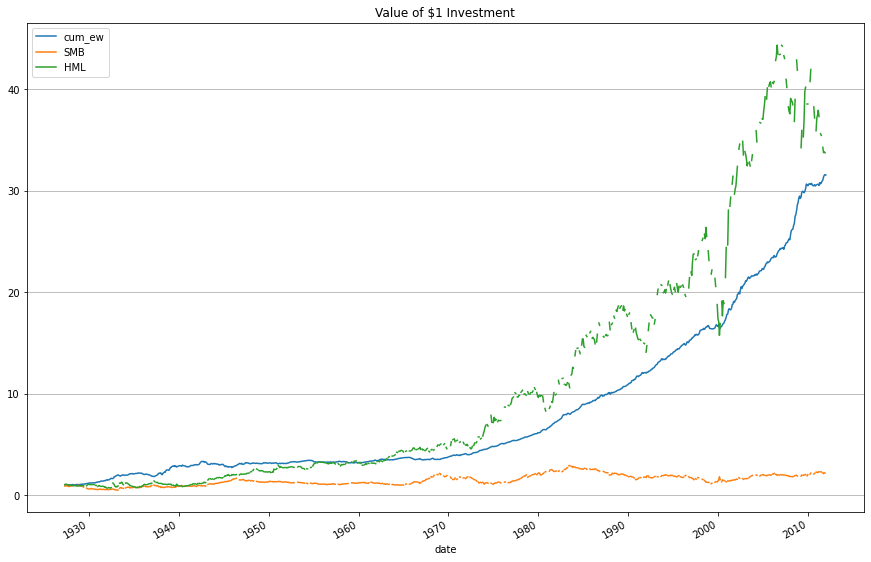

In [136]:
# Figure 1
portfolios = pd.DataFrame()
portfolios['cum_ew'] = (longshortport_eq['longshort_eq'] + 1).cumprod()
# print(portfolios['cum_ew'])
portfolios['cum_vw'] = (longshortport_vw['longshort_vw'] + 1).cumprod()
portfolios['SMB']= (ff4['smb']+ 1).cumprod()
portfolios['HML']= (ff4['hml']+ 1).cumprod()
portfolios=portfolios.reset_index()
portfolios
# Within-companies Predicted Dividend Portfolio
(
    portfolios
    .assign(date=pd.to_datetime(portfolios['date']))
    .assign(cum_ew=portfolios['cum_ew'])
    # .assign(cum_vw=portfolios['cum_vw'])
    .assign(SMB=portfolios['SMB'])
    .assign(HML=portfolios['HML'])
    .plot(x='date', y=['cum_ew','SMB','HML'],figsize=(15,10),title='Value of $1 Investment').grid(axis='y')
)